In [6]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

In [7]:
import os

# Check current directory
print("Current directory:", os.getcwd())

# Change to the desired directory
os.chdir(r'C:\Users\PC\ProjetGoMyCode')

# Verify that the directory has changed
print("New working directory:", os.getcwd())


Current directory: C:\Users\PC\ProjetGoMyCode
New working directory: C:\Users\PC\ProjetGoMyCode


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [9]:
POS_PATH = os.path.join ('data', 'positive')
NEG_PATH = os.path.join ('data', 'negative')
ANC_PATH = os.path.join ('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import uuid

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    #cut down frame to 250x250 pixels
    frame = frame[120:120+250,200:200+250, : ]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname= os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname= os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
        
    #show image 
    cv2.imshow('Image Collection', frame)
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
   
        
# Release the webcamq
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [10]:
##Form a dataset from our photos
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\86b53dbf-7512-11ef-a669-10653073972e.jpg'


In [13]:
#processing : scaling and resizing the data

def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image 
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [17]:
samples = data.as_numpy_iterator()

In [18]:
example = samples.next()

In [19]:
example

(b'data\\anchor\\862437af-7512-11ef-96dd-10653073972e.jpg',
 b'data\\positive\\d6b40727-7512-11ef-a1dc-10653073972e.jpg',
 1.0)

In [16]:
#Create lablelles dataset ( 0 and 1)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
#Build Train and Test partition

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


In [21]:
res = preprocess_twin(*example)


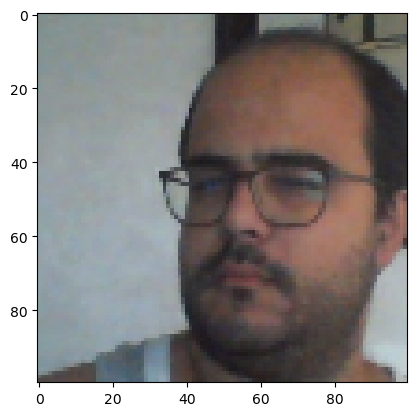

In [22]:
plt.imshow(res[1])

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [24]:
samples = data.as_numpy_iterator()
samples.next()

(array([[[0.5139706 , 0.5884804 , 0.5806373 ],
         [0.5061275 , 0.5806373 , 0.57279414],
         [0.50759804, 0.58210784, 0.5742647 ],
         ...,
         [0.6526961 , 0.51911765, 0.42034313],
         [0.6526961 , 0.5154412 , 0.43504903],
         [0.6519608 , 0.5127451 , 0.4362745 ]],
 
        [[0.5264706 , 0.5882353 , 0.5745098 ],
         [0.5203431 , 0.5838235 , 0.5713235 ],
         [0.5227941 , 0.5877451 , 0.58259803],
         ...,
         [0.6367647 , 0.5090686 , 0.4137255 ],
         [0.6382353 , 0.5127451 , 0.41960785],
         [0.6333333 , 0.50980395, 0.41470587]],
 
        [[0.53137255, 0.58431375, 0.5588235 ],
         [0.52916664, 0.5882353 , 0.57058823],
         [0.5352941 , 0.59289217, 0.5892157 ],
         ...,
         [0.63553923, 0.4982843 , 0.41642156],
         [0.63284314, 0.50514704, 0.40980393],
         [0.63039213, 0.50980395, 0.4       ]],
 
        ...,
 
        [[0.30980393, 0.4509804 , 0.5137255 ],
         [0.30490196, 0.4365196 , 0.50882

In [26]:
samp = samples.next()

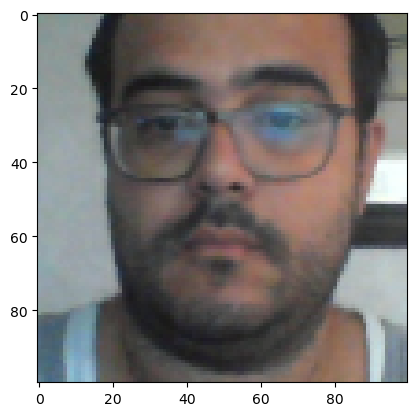

In [27]:
plt.imshow(samp[0])

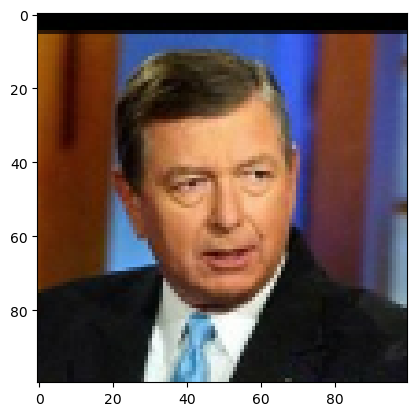

In [28]:
plt.imshow(samp[1])

In [29]:
samp[2]

0.0

In [30]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


In [31]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Make embedding model

In [32]:
inp = Input(shape=(100,100,3), name='input_image')

In [33]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [34]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [35]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [36]:
m2

<KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, name=keras_tensor_3>

In [37]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [38]:
m3

<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, name=keras_tensor_5>

In [39]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [40]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
 def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [43]:
embedding = make_embedding()

In [44]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [46]:
l1 = L1Dist()

# Make Siamese Model

In [47]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [48]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [49]:
siamese_layer = L1Dist()

In [50]:
distances = siamese_layer(inp_embedding, val_embedding)

In [51]:
classifier = Dense(1, activation='sigmoid')(distances)

In [52]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [53]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [54]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [56]:
siamese_model = make_siamese_model()

In [57]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Loss function and Optimizer

In [58]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [59]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# Checkpoints

In [60]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Train step function

In [61]:
test_batch = train_data.as_numpy_iterator()

In [62]:
batch_1 = test_batch.next()

In [63]:
len(batch_1[2])

16

In [64]:
X= batch_1[:2]

In [65]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [66]:
Y= batch_1[2]

In [67]:
Y

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

In [68]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    tf.print("Loss:", loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [69]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [71]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


 Epoch 1/50
Loss: 0.695117831
 1/27 ━━━━━━━━━━━━━━━━━━━━ 6:13 14s/stepLoss: 0.692963362
 2/27 ━━━━━━━━━━━━━━━━━━━━ 3:02 7s/step Loss: 0.676707268
 3/27 ━━━━━━━━━━━━━━━━━━━━ 2:59 7s/stepLoss: 0.652188241
 4/27 ━━━━━━━━━━━━━━━━━━━━ 2:53 8s/stepLoss: 0.628044844
 5/27 ━━━━━━━━━━━━━━━━━━━━ 2:46 8s/stepLoss: 0.543798685
 6/27 ━━━━━━━━━━━━━━━━━━━━ 2:39 8s/stepLoss: 0.513544202
 7/27 ━━━━━━━━━━━━━━━━━━━━ 2:33 8s/stepLoss: 0.4330208
 8/27 ━━━━━━━━━━━━━━━━━━━━ 2:25 8s/stepLoss: 0.362637192
 9/27 ━━━━━━━━━━━━━━━━━━━━ 2:17 8s/stepLoss: 0.336577654
10/27 ━━━━━━━━━━━━━━━━━━━━ 2:09 8s/stepLoss: 0.251565069
11/27 ━━━━━━━━━━━━━━━━━━━━ 2:01 8s/stepLoss: 0.317222923
12/27 ━━━━━━━━━━━━━━━━━━━━ 1:54 8s/stepLoss: 0.230605334
13/27 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/stepLoss: 0.471522629
14/27 ━━━━━━━━━━━━━━━━━━━━ 1:39 8s/stepLoss: 0.173964411
15/27 ━━━━━━━━━━━━━━━━━━━━ 1:31 8s/stepLoss: 0.170478418
16/27 ━━━━━━━━━━━━━━━━━━━━ 1:24 8s/stepLoss: 0.311219424
17/27 ━━━━━━━━━━━━━━━━━━━━ 1:16 8s/stepLoss: 0.201951742


# Evalute our model

In [73]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [74]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [75]:
y_true

array([1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [76]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0000000e+00],
       [9.2358920e-07],
       [1.0000000e+00],
       [8.0989906e-08],
       [8.2953662e-09],
       [9.9998468e-01],
       [9.9938965e-01],
       [5.0345452e-08],
       [2.2995160e-08],
       [9.9999821e-01],
       [2.6781076e-05],
       [9.9999994e-01],
       [9.9935460e-01],
       [3.2107086e-09],
       [9.9999982e-01],
       [9.9999148e-01]], dtype=float32)

In [77]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]

In [82]:
y_true[3]

0.0

# Metrics


In [79]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [80]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

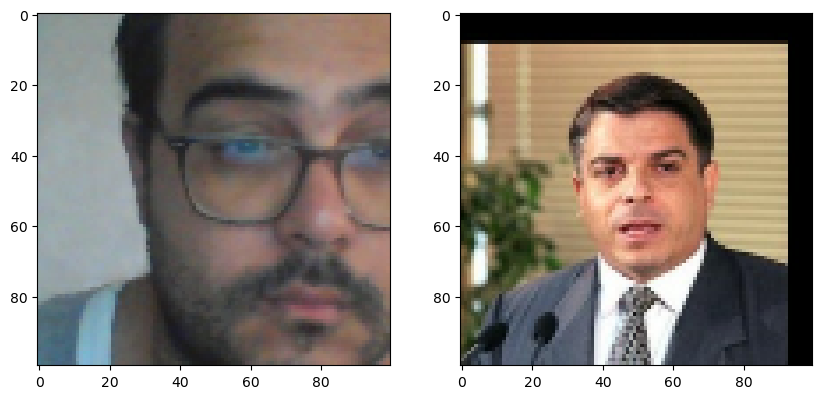

In [81]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# Save model

In [83]:
siamese_model.save('siamesemodel.h5')

In [84]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [85]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[1.0000000e+00],
       [9.2358920e-07],
       [1.0000000e+00],
       [8.0989906e-08],
       [8.2953662e-09],
       [9.9998468e-01],
       [9.9938965e-01],
       [5.0345452e-08],
       [2.2995160e-08],
       [9.9999821e-01],
       [2.6781076e-05],
       [9.9999994e-01],
       [9.9935460e-01],
       [3.2107086e-09],
       [9.9999982e-01],
       [9.9999148e-01]], dtype=float32)

In [86]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Real time verification

In [87]:
#Verification function
def verify(model, detection_threshold, verification_threshold):
     # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
        
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
     # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    
    return results, verified

# OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()